## Домашнее здание №3 / New Product Forecasting

### Фамилия Имя / Группа

----
План выполнения домашнего задания:

1. Подготовка данных
2. Предсказание без категориальных признаков
3. Предсказание с категориальными признаками
4.  Другие модели и генерация дополнительных признаков
5. Отправка результатов в контест на Kaggle

In [1]:
import pandas as pd
import numpy as np
from random import shuffle
from sklearn import tree
from copy import deepcopy
from sklearn.ensemble import BaggingRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import cross_validation
from sklearn.dummy import DummyRegressor
from scipy.optimize import minimize_scalar
%matplotlib inline

## Подготовка данных (1 балл)
 * Изучить признаки
 * Выделить категориальные признаки, которые можно использовать для обучения
 * Выделить датасет только с числовыми признаками
 * Выделить полезные числовые признаки

In [146]:
# data = pd.read_csv('blogData_train.csv', header=None)
data = pd.read_csv('./data/train.csv', sep=';', index_col='ID')
data.shape

(40000, 33)

In [147]:
# Посмотрим на данные
data.head()

,DEMAND,LOCATION_ID,MODEL_BRAND,MODEL_COST_AVG,MODEL_COUNT_SALES_DAYS,MODEL_DIAG,MODEL_DIAG_TYPE,MODEL_HEIGHT,MODEL_ID,MODEL_MEAN_SALES,...,STORE_FORMAT,STORE_OPEN_DTTM,STORE_PRICE_TYPE,STORE_REGION,STORE_RES_ABC,STORE_RES_SPECTR,STORE_TYPE_A,STORE_TYPE_B,STORE_TYPE_C,STORE_TYPE_SPECTR
ID,,,,,,,,,,,,,,,,,,,,,
0,0.10536,1835543262,ark,5179.7500,NaN,5.5,big,720.0,1682,NaN,...,новый формат,19MAY15:00:00:00,розничная цена (северо-запад-санкт-петербург),северо-запад,B,0.67,0.75,0.25,0.0,3.06
1,0.00010,1972241965,samsung,22015.3300,NaN,5.2,big,1920.0,34706,NaN,...,новый формат,20JAN16:00:00:00,розничная цена (северо-запад-днс1),северо-запад,C,0.48,0.00,1.00,0.0,2.51
2,0.00010,2027986985,samsung,15592.5900,NaN,5.0,big,1280.0,2753,NaN,...,новый формат,27APR16:00:00:00,розничная цена (дальний восток-якутск),дальний восток,A,0.64,1.00,0.00,0.0,2.72
3,0.00010,28432,alcatel,540.9533,29.0,1.8,small,128.0,1593,7.533,...,стандарт,21OCT09:00:00:00,розничная цена (северо-запад-боровичи),северо-запад,B,0.65,0.50,0.25,0.0,2.04
4,0.00010,28547,мтс,444.7300,30.0,4.0,medium,480.0,80644,16.830,...,стандарт,20MAY09:00:00:00,розничная цена (северо-запад-санкт-петербург),северо-запад,A,0.83,0.75,0.25,0.0,2.37


### Категориальные признаки
 * Какие категориальные признаки следует использовать в первую очередь? 
 * Есть ли категориальные признаки, которые в принципе не понятно, как использовать?

In [148]:
# Определяем категориальные признаки
# По понятным причинам 'LOCATION_ID', 'MODEL_ID' считаются числовыми признаками - их добавляем руками отдельно
Categorical_columns = data.columns[([isinstance(z, str) for z in data.ix[0]])]
Categorical_columns

Index([u'MODEL_BRAND', u'MODEL_DIAG_TYPE', u'MODEL_NAME', u'MODEL_OS',
       u'MODEL_RES_TYPE', u'MODEL_TYPE', u'STORE_BRAND_ABC',
       u'STORE_BUILDING_TYPE', u'STORE_CITY', u'STORE_CLUSTER',
       u'STORE_DIAG_ABC', u'STORE_FORMAT', u'STORE_OPEN_DTTM',
       u'STORE_PRICE_TYPE', u'STORE_REGION', u'STORE_RES_ABC'],
      dtype='object')

In [149]:
# Количество уникальных значений в категориальных признаках
dist_val = pd.DataFrame({'NoUniqueValues': [data[z].nunique() for z in Categorical_columns]}, index = Categorical_columns)

print('Количество уникальных категориальных значений: '+ str(dist_val.sum().values))
print('Удаляем признаки с номерами: \n'+ str(dist_val.ix[dist_val['NoUniqueValues']>0].sort_values(by='NoUniqueValues', ascending=False)))

Количество уникальных категориальных значений: [845]
Удаляем признаки с номерами: 
                     NoUniqueValues
MODEL_NAME                      447
STORE_OPEN_DTTM                 246
STORE_CITY                       36
MODEL_BRAND                      33
STORE_CLUSTER                    23
STORE_PRICE_TYPE                 20
STORE_FORMAT                     10
MODEL_OS                          5
STORE_REGION                      5
MODEL_DIAG_TYPE                   3
MODEL_RES_TYPE                    3
STORE_BRAND_ABC                   3
STORE_BUILDING_TYPE               3
STORE_DIAG_ABC                    3
STORE_RES_ABC                     3
MODEL_TYPE                        2


In [ ]:
# Запоминаем те категориальные признаки, с которыми не будем далее работать (используется далее)
Categorical_columns_use = Cathegorical_columns[номера полезных категориальных фич]

### Числовые признаки
* Какие числовые признаки следует использовать в первую очередь? 
* Есть ли числовые признаки, которые в принципе не понятно, как использовать?
* Как заполнять NaN?

In [283]:
# Выделяем числовой датасет: В данном случае удаляем все + MODEL_ID и LOCATION_ID
num_data = data.drop(Cathegorical_columns | data.columns[[1,8]], axis = 1)
num_data.columns

Index([u'DEMAND', u'MODEL_COST_AVG', u'MODEL_COUNT_SALES_DAYS', u'MODEL_DIAG',
       u'MODEL_HEIGHT', u'MODEL_MEAN_SALES', u'MODEL_WIDTH',
       u'STORE_ASSORTMENT', u'STORE_BRAND_SPECTR', u'STORE_DIAG_SPECTR',
       u'STORE_RES_SPECTR', u'STORE_TYPE_A', u'STORE_TYPE_B', u'STORE_TYPE_C',
       u'STORE_TYPE_SPECTR'],
      dtype='object')

In [151]:
# Количество NaN в числовых признаках
print('Количество NaN:')
nan_val = num_data.isnull().sum().T
nan_val
# print('Удаляем признаки с номерами: \n'+ str(nan_val.sort_values(by='NoUniqueValues', ascending=False)))

Количество NaN:


DEMAND                        0
MODEL_COST_AVG                0
MODEL_COUNT_SALES_DAYS    18917
MODEL_DIAG                  212
MODEL_HEIGHT                212
MODEL_MEAN_SALES          18917
MODEL_WIDTH                 212
STORE_ASSORTMENT            235
STORE_BRAND_SPECTR          235
STORE_DIAG_SPECTR           442
STORE_RES_SPECTR            446
STORE_TYPE_A                  0
STORE_TYPE_B                  0
STORE_TYPE_C                  0
STORE_TYPE_SPECTR             0
dtype: int64

##### Преобразовываем числовые признаки (удаляем/добавляем/заменяем nan)

In [ ]:
# Здесь добавьте код по преобразованию числовых признаков

# пример
num_data[???][num_data[???]<числовой порог]=значение

In [152]:
# Здесь добавьте код по заполнению NaN
num_data = num_data[список фич].fillna(значение)


Index([u'DEMAND', u'MODEL_COST_AVG', u'MODEL_DIAG', u'MODEL_MEAN_SALES',
       u'STORE_BRAND_SPECTR', u'STORE_DIAG_SPECTR', u'STORE_RES_SPECTR',
       u'STORE_TYPE_A', u'STORE_TYPE_B', u'STORE_TYPE_C',
       u'STORE_TYPE_SPECTR'],
      dtype='object')

In [ ]:
# Здесь добавьте код по удалению числовых признаков
num_data.drop([список фич], axis = 1, inplace=True)
num_data.columns

## Предсказание без категориальных признаков (1 балл)
### Вспомогательные функции

In [153]:
def smape_loss_func(x, y):
    SymAPE = [ 2*np.abs(x-y)/(np.abs(x)+np.abs(y))] 
    return np.mean(SymAPE)

def get_numerated_data(df, categorical_columns):
    simple_df = deepcopy(df)
    for column in categorical_columns:
        simple_df[column] = pd.Categorical.from_array(simple_df[column]).labels
    
    return simple_df

def get_binarized_data(df, categorical_columns):
    binary_df = deepcopy(df)
    for column in categorical_columns:
        binary_df = pd.concat([binary_df, pd.get_dummies(binary_df[column], prefix=column, prefix_sep=': ')], axis=1)
        del binary_df[column]
    
    return binary_df

def split_to_numpy(df, y_column_name):
    #print df
    #print y_column_name
    data_x = df.drop(y_column_name, axis=1).values.astype(np.float32)
    data_y = df[y_column_name].values.astype(np.float32)
    column_names = df.drop(y_column_name, axis=1).columns
    
    return data_x, data_y, column_names

def split_train_test(df, test_size=0.5, random_state=42, y_column_name='y'):
    X = np.asarray(df.drop(y_column_name, axis=1))
    y = np.asarray(df[y_column_name]).ravel()
    trainX, testX, trainY, testY = cross_validation.train_test_split(X, y, test_size=test_size, random_state=42)
    return trainX, testX, trainY, testY

### Необходимые функции

In [274]:
def show_plot(n_est, res, title="", ylabel="acc"):
    fig, ax = plt.subplots()
    ax.plot(n_est, [res[x][1] for x in n_est], 'ro')
#     ax.set_xlim((np.min(n_est) - 10, np.max(n_est) + 10))
#     plt.xlabel("n_estimators")
#     plt.ylabel(ylabel)
#     plt.title("Test result")
#     plt.show()
    
#     fig, ax = plt.subplots()
    ax.plot(n_est, [res[x][0] for x in n_est], 'bo')
    ax.set_xlim((np.min(n_est) - 10, np.max(n_est) + 10))
    plt.xlabel("n_estimators")
    plt.ylabel("acc")
    plt.title(title)
    plt.show()

def get_results_dummy_reg(acc=smape_loss_func, verbose=True, strg ='mean', const=None):
    results = dict()
    reg = DummyRegressor(strategy=strg, constant=const)
    reg.fit(trainX, trainY)
    predict = reg.predict(testX)
    results[1] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
    if verbose:
        print("Accuracy: " + str(results[1][1]))
    return results

def get_results_baggind_rsm(n_est, max_samples, max_features, acc=smape_loss_func, verbose=True):
    results = dict()
    for i in n_est:
        reg = BaggingRegressor(n_estimators=i,
                          max_samples=max_samples, max_features=max_features, random_state=1234, n_jobs=-1, verbose=0)
        reg.fit(trainX, trainY)
#         results[i] = (mse(reg.predict(trainX), trainY), mse(reg.predict(testX), testY))
        predict = reg.predict(testX)
        results[i] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))
    return results

def get_results_rf(n_est, oob=False, verbose=True, acc=smape_loss_func):
    results = dict()
    for i in n_est:
        reg = RandomForestRegressor(n_estimators=i, n_jobs=-1, random_state=1234, verbose=0,
                                    oob_score=oob, max_features='sqrt')
        reg.fit(trainX, trainY)
        predict = reg.predict(testX)
        if oob:
            results[i] = (reg.oob_score_, acc(predict, testY))
        else:
            results[i] = (acc(trainY, reg.predict(trainX)), acc(testY,predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))
    return results

def get_results_erte(n_est, verbose=True,acc=smape_loss_func):
    results = dict()
    for i in n_est:
        reg = ExtraTreesRegressor(n_estimators=i, n_jobs=-1, random_state=12, verbose=0)
        reg.fit(trainX, trainY)
        predict = reg.predict(testX)
        results[i] = (acc(trainY,reg.predict(trainX)), acc(round_predict(predict), testY))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))
    return results

def get_results_gbdt(n_est, verbose=True, init=None, acc=smape_loss_func, min_max_filter=True, max_val=1, min_val=0.001):
    results = dict()
    for i in n_est:
        if init is not None:
            reg = GradientBoostingRegressor(n_estimators=i, random_state=1234, verbose=0, init=init)
        else:
            reg = GradientBoostingRegressor(n_estimators=i, random_state=1234, verbose=0)
        reg.fit(trainX, trainY)
        predict = reg.predict(testX)
        if min_max_filter:
            predict = np.minimum(np.maximum(predict, min_val),max_val)
        results[i] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))    
    return results

def get_optimal(results):
    results = sorted(results, key=lambda x: x[1])

### Делим выборку на обучение и контроль

In [289]:
trainX, testX, trainY, testY = split_train_test(df = num_data, test_size=0.1,  y_column_name='DEMAND')

### DummyRegressor
* Самый простой классификатор на числовых признаках используется как база для сравнения

In [290]:
%time results = get_results_dummy_reg()
%time results = get_results_dummy_reg(strg='constant', const=0.001)

Accuracy: 1.24306344718
Wall time: 6 ms
Accuracy: 1.81014628129
Wall time: 6 ms


### Bagging and RSM
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

** Каким стоит брать размер bootstrap выборки и RSM выборки ** 
Например: 
**Bagging:** 0.5 от размера тестовой выборки.

**RSM:** 0.5 от размера тестовой выборки.

Count of estimators: 10, accuracy: 1.22100959435
Count of estimators: 20, accuracy: 1.21464057747
Count of estimators: 30, accuracy: 1.21876562442
Count of estimators: 40, accuracy: 1.21986437423
Count of estimators: 50, accuracy: 1.22145407565
Count of estimators: 60, accuracy: 1.22347891479
Count of estimators: 70, accuracy: 1.22462831779
Count of estimators: 80, accuracy: 1.22489412308
Count of estimators: 90, accuracy: 1.22280745976
Count of estimators: 100, accuracy: 1.22166409119
Count of estimators: 110, accuracy: 1.22188407676
Count of estimators: 120, accuracy: 1.22122092478
Count of estimators: 130, accuracy: 1.2213443006
Count of estimators: 140, accuracy: 1.22175209425
Wall time: 3min 37s


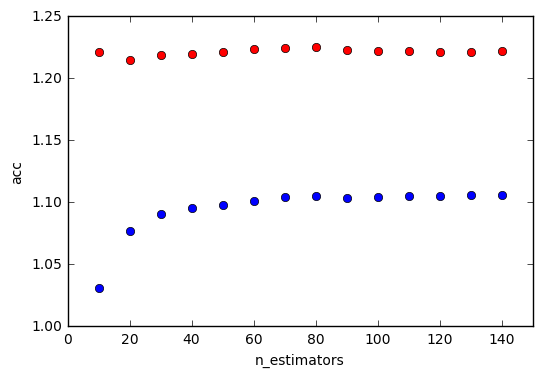

In [291]:
n_est = range(10, 150, 10)
%time results = get_results_baggind_rsm(n_est, 0.5, 0.5, verbose=True)
show_plot(n_est, results)

### Random Forest
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.22135764692
Count of estimators: 20, accuracy: 1.22774792977
Count of estimators: 30, accuracy: 1.22424763301
Count of estimators: 40, accuracy: 1.22253165976
Count of estimators: 50, accuracy: 1.22237788476
Count of estimators: 60, accuracy: 1.22070273232
Count of estimators: 70, accuracy: 1.22296725441
Count of estimators: 80, accuracy: 1.22106760638
Count of estimators: 90, accuracy: 1.22032673592
Count of estimators: 100, accuracy: 1.2203797987
Count of estimators: 110, accuracy: 1.2204736192
Count of estimators: 120, accuracy: 1.22014865746
Count of estimators: 130, accuracy: 1.21972579884
Count of estimators: 140, accuracy: 1.21955649699
Wall time: 1min 26s


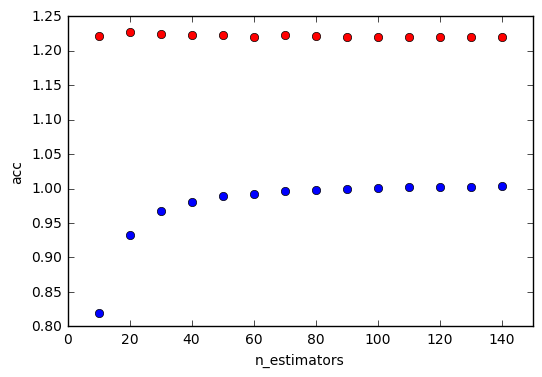

In [129]:
n_est = range(10, 150, 10)
%time results = get_results_rf(n_est)
show_plot(n_est, results)

### Extremely Randomized Trees Ensemble
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.98884881864
Count of estimators: 20, accuracy: 1.98505176135
Count of estimators: 30, accuracy: 1.98620493766
Count of estimators: 40, accuracy: 1.98656959935
Count of estimators: 50, accuracy: 1.987304438
Count of estimators: 60, accuracy: 1.98731209132
Count of estimators: 70, accuracy: 1.98723065888
Count of estimators: 80, accuracy: 1.98840768639
Count of estimators: 90, accuracy: 1.98867925869
Count of estimators: 100, accuracy: 1.98781056218
Count of estimators: 110, accuracy: 1.9882795225
Count of estimators: 120, accuracy: 1.98808843425
Count of estimators: 130, accuracy: 1.98799956513
Count of estimators: 140, accuracy: 1.98834199663
Wall time: 1min 42s


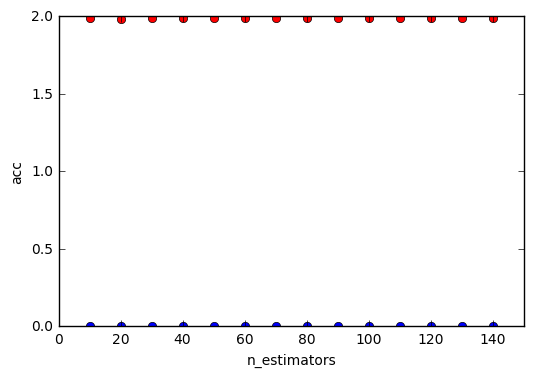

In [140]:
n_est = range(10, 150, 10)
%time results = get_results_erte(n_est)
show_plot(n_est, results)

## Gradient Boosted Decision Trees
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.23570798832
Count of estimators: 20, accuracy: 1.23008633135
Count of estimators: 30, accuracy: 1.22526355815
Count of estimators: 40, accuracy: 1.2237483783
Count of estimators: 50, accuracy: 1.22494743886
Count of estimators: 60, accuracy: 1.22768846258
Count of estimators: 70, accuracy: 1.22889354167
Count of estimators: 80, accuracy: 1.23091338635
Count of estimators: 90, accuracy: 1.23321877478
Count of estimators: 100, accuracy: 1.23282568198
Count of estimators: 110, accuracy: 1.23564785921
Count of estimators: 120, accuracy: 1.23914083316
Count of estimators: 130, accuracy: 1.23878062341
Count of estimators: 140, accuracy: 1.23967874986
Wall time: 27.1 s


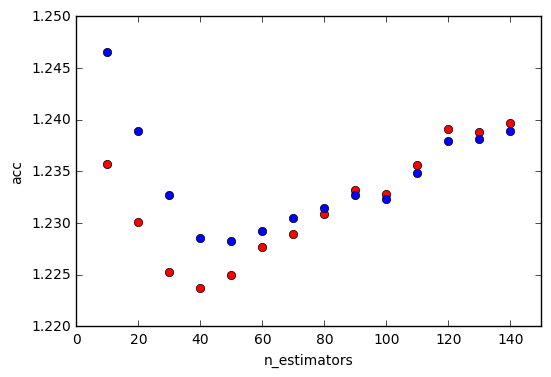

In [141]:
n_est = range(10, 150, 10)
%time results = get_results_gbdt(n_est)
show_plot(n_est, results)

### Вывод
Переобучаются ExtraDT, остальные методы показывают результаты на одном уровне (в пределах погрешности).

Для RF и Baggin+RSM оптимальные значения кол-ва близко к 20.

Для GBDT оптимальное количество алгоритмов находится в районе 50.

**Вопрос: Дайте интепретацию полученным результатам в вашем случае.**

Bagging и Boosting дают примерно одинаковые результаты: нужно работать как над уменьшением смещения, так и разброса.
Видимо, ...

## Использование категориальных признаков (1 балл)
* Проведите аналогичный экспермент при наличии категориальных признаков

### Обучение и Контроль

In [155]:
Cathegorical_columns

Index([u'MODEL_BRAND', u'MODEL_DIAG_TYPE', u'MODEL_NAME', u'MODEL_OS',
       u'MODEL_RES_TYPE', u'MODEL_TYPE', u'STORE_BRAND_ABC',
       u'STORE_BUILDING_TYPE', u'STORE_CITY', u'STORE_CLUSTER',
       u'STORE_DIAG_ABC', u'STORE_FORMAT', u'STORE_OPEN_DTTM',
       u'STORE_PRICE_TYPE', u'STORE_REGION', u'STORE_RES_ABC'],
      dtype='object')

In [276]:
# Для обучения используются полезные категориальные признаки
bin_data = get_binarized_data(data, Cathegorical_columns_use)
print(bin_data.shape)

(40000, 148)


##### Исключаем лишние произнаки, заменяем NaN

In [ ]:
# Удаляем лишние категоримальные признаки
bin_data.drop(Cathegorical_columns[лишние категориальные признаки], axis = 1, inplace=True)

In [ ]:
# Удаляем лишние числвые признаки признаки
bin_data = bin_data.drop([лишние числовые признаки], axis = 1, inplace = True)

# Заменяем NaN
bin_data.fillna(значение, inplace = True)

In [292]:
# Делим выборку на обучение и контроль
trainX, testX, trainY, testY = split_train_test(df = bin_data, test_size=0.1,  y_column_name='DEMAND')

### Bagging and RSM
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.15699968877
Count of estimators: 20, accuracy: 1.18203437582
Count of estimators: 30, accuracy: 1.18645092593
Count of estimators: 40, accuracy: 1.1896945103
Count of estimators: 50, accuracy: 1.19407763041
Count of estimators: 60, accuracy: 1.19573702042
Count of estimators: 70, accuracy: 1.19544348245
Count of estimators: 80, accuracy: 1.19694194811
Count of estimators: 90, accuracy: 1.19571517851
Count of estimators: 100, accuracy: 1.19695077391
Count of estimators: 110, accuracy: 1.19581644326
Count of estimators: 120, accuracy: 1.19506062393
Count of estimators: 130, accuracy: 1.19445445735
Count of estimators: 140, accuracy: 1.19348136202
Wall time: 13min 17s


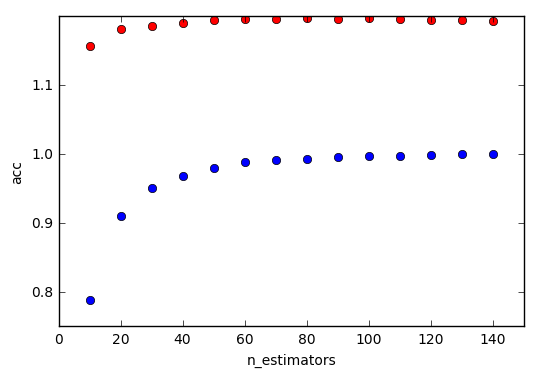

In [293]:
n_est = range(10, 150, 10)
%time results = get_results_baggind_rsm(n_est, 0.9, 0.9, verbose=True)
show_plot(n_est, results)

### Random Forest
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.19862745577
Count of estimators: 20, accuracy: 1.19975802945
Count of estimators: 30, accuracy: 1.19642767719
Count of estimators: 40, accuracy: 1.19905233741
Count of estimators: 50, accuracy: 1.19884698082
Count of estimators: 60, accuracy: 1.19969109102
Count of estimators: 70, accuracy: 1.19842426057
Count of estimators: 80, accuracy: 1.19801113168
Count of estimators: 90, accuracy: 1.19935679762
Count of estimators: 100, accuracy: 1.19754900612
Count of estimators: 110, accuracy: 1.19761727374
Count of estimators: 120, accuracy: 1.19875166048
Count of estimators: 130, accuracy: 1.19970926401
Count of estimators: 140, accuracy: 1.19946135197
Wall time: 1min 39s


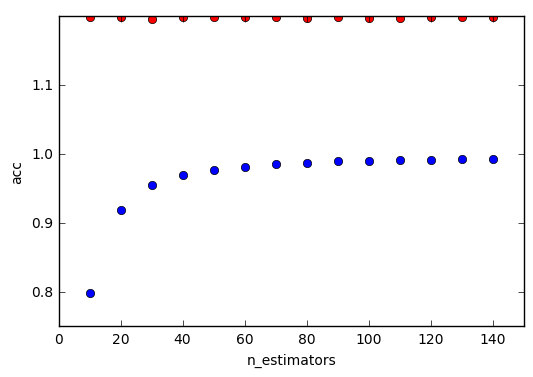

In [279]:
n_est = range(10, 150, 10)
%time results = get_results_rf(n_est)
show_plot(n_est, results)

### Extremely Randomized Trees Ensemble
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.98787789468
Count of estimators: 20, accuracy: 1.98365737576
Count of estimators: 30, accuracy: 1.9817152687
Count of estimators: 40, accuracy: 1.98163912705
Count of estimators: 50, accuracy: 1.98285835431
Count of estimators: 60, accuracy: 1.98346790057
Count of estimators: 70, accuracy: 1.98412016812
Count of estimators: 80, accuracy: 1.98429575357
Count of estimators: 90, accuracy: 1.9843401346
Count of estimators: 100, accuracy: 1.98458447444
Count of estimators: 110, accuracy: 1.98548507553
Count of estimators: 120, accuracy: 1.98418310327
Count of estimators: 130, accuracy: 1.98383253052
Count of estimators: 140, accuracy: 1.98409054326
Wall time: 13min 9s


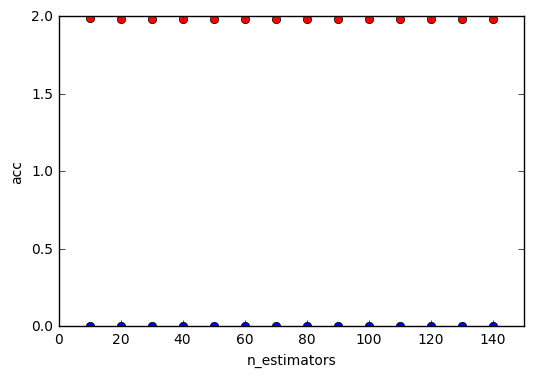

In [168]:
n_est = range(10, 150, 10)
%time results = get_results_erte(n_est)
show_plot(n_est, results)

### Gradient Boosted Decision Trees
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.23257783171
Count of estimators: 20, accuracy: 1.2280815379
Count of estimators: 30, accuracy: 1.22350560247
Count of estimators: 40, accuracy: 1.22092744748
Count of estimators: 50, accuracy: 1.21887741019
Count of estimators: 60, accuracy: 1.21758012769
Count of estimators: 70, accuracy: 1.22035844913
Count of estimators: 80, accuracy: 1.21947466007
Count of estimators: 90, accuracy: 1.21960799203
Count of estimators: 100, accuracy: 1.21961919574
Count of estimators: 110, accuracy: 1.21871894449
Count of estimators: 120, accuracy: 1.21833941747
Count of estimators: 130, accuracy: 1.21784221935
Count of estimators: 140, accuracy: 1.21661593315
Wall time: 4min 33s


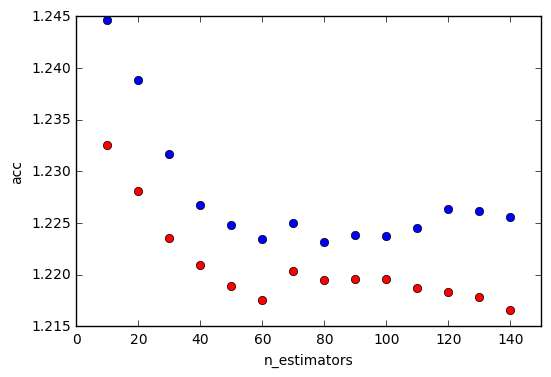

In [278]:
n_est = range(10, 150, 10)
%time results = get_results_gbdt(n_est)
show_plot(n_est, results)

### Вывод

**Вопрос: Дайте интепретацию полученным результатам в вашем случае.**

## Другие модели и генерация дополнительных признаков (2 балла)

* На основании сделанных выводов, предложите другой вариант алгоритма ML, который должен показать лучший результат
* Направляния:
    -- использовать принципиально другое семейство алгоритмов (NN, GB+kNN, LinearRegression, композиция Baggin и GBDT)
    -- исключить бесполезные фичи из обучающей выборки (полезность фич проанализировать с помощью RF);
    -- исключить фичи, в которых есть NaN; сделать восстановление NaN более интеллектуально;
    -- преобразовать катеориальные признаки так, чтобы получились числовые.

### Вывод

## Отправка результатов в контест на Kaggle (оценивается по результатам в Leaderboard)

In [225]:
test = pd.read_csv('./data/test.csv', sep=';',decimal= '.', index_col='ID')

In [265]:
# Предобработка тестовой выборки (добавляем\удаляем признаки, предобработка NaN и пр.)
test_data = get_binarized_data(test, Cathegorical_columns[категориальные признаки])

In [266]:
# Все отсутствующие в тестовой выборке столбцы полагаем 0
add_columns = bin_data.columns[1:].difference(test_data.columns)
test_data = pd.merge(test_data, bin_data.ix[test_data.index][add_columns], how='inner', left_index=True, right_index=True)
test_data[add_columns]=0

# Оставляем только столбцы обучающей выборки (целевая переменная в обучающей выборке отсутствует)
test_data = test_data[bin_data.columns[1:]]

test_data = test_data.fillna(-10, inplace=True)

In [ ]:
# Обучающая выборка
trainX, _, trainY, _ = split_train_test(df = bin_data, test_size=0,  y_column_name='DEMAND')

In [294]:
# Обучаем финальный алгоритм
final_regressor = финальный алгоритм
final_regressor.fit(trainX, trainY)

In [271]:
# Предсказание интенсивности
test_predict = final_regressor.predict(np.asarray(test_data))

In [273]:
# Сохраняем в csv-файл
test['DEMAND'] = test_predict
test[['DEMAND']].to_csv('./data/submission_gbdt.csv', sep = ',', index = True)